# Setup

In [ ]:
!pip install -qU langchain
!pip install -qU langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-qdrant
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install fastembed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [269]:
import os
from dotenv import load_dotenv

load_dotenv()

# for colab
# from google.colab import userdata

# os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api_key')
# os.environ["HUGGINGFACE_API_KEY"] = userdata.get('huggingface_api_key')
# os.environ["LANGSMITH_API_KEY"] = userdata.get('langsmith_api_key')
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = "nlp_project"

True

In [270]:
from huggingface_hub import login

login(token=os.getenv("HUGGINGFACE_API_KEY"))
print("Logged in successfully!")

Logged in successfully!


In [271]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [272]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d3830a95-ace8-465b-85f4-e692c956dcb9-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings

model_kwargs = {'trust_remote_code': True}
embeddings = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-modernbert-base", model_kwargs=model_kwargs)

In [6]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="Alibaba-NLP/gte-reranker-modernbert-base")

In [301]:
import pandas as pd
import numpy as np
from tqdm import tqdm

submissions = pd.read_csv("./data/submissions.csv")
submissions = submissions[submissions["score"] == 100.0]

generated_submissions = pd.read_csv("./data/generated_submissions.csv")
generated_submissions.drop_duplicates(subset="code", inplace=True)

human_submissions = submissions[submissions["not_generated"] == True]
sus_submissions = submissions[submissions["not_generated"] == False]

rag_submissions = pd.concat([human_submissions, generated_submissions], ignore_index=True)
sus_submissions = sus_submissions.reset_index(drop=True)

human_submissions.shape, sus_submissions.shape, generated_submissions.shape, rag_submissions.shape

((6318, 8), (1718, 8), (329, 8), (6647, 8))

In [27]:
rag_submissions

,id,author,problem_id,code,submission_id,score,time,not_generated
0,1255109.0,6330139021,05_List_11,x = input()\na = [str(i) for i in range(10)]\n...,1255109.0,100.0,over 4 years ago,True
1,1257085.0,6330004021,05_List_11,"n=input()\nans=''\ndg=['0','1','2','3','4','5'...",1257085.0,100.0,over 4 years ago,True
2,1255424.0,6330015921,05_List_11,"a=input()\nb=[]\nc=""""\nfor ch in a:\n if""0""...",1255424.0,100.0,over 4 years ago,True
3,1047529.0,6230080521,05_List_11,"a=input().strip()\nn=['0','1','2','3','4','5',...",1047529.0,100.0,over 5 years ago,True
4,1253956.0,6231007021,05_List_11,"dg = ['0','1','2','3','4','5','6','7','8','9']...",1253956.0,100.0,over 4 years ago,True
...,...,...,...,...,...,...,...,...
4848,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n ice_cr...,NaN,NaN,2025-03-21 19:43:16.459842,False
4849,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n prices...,NaN,NaN,2025-03-21 19:43:18.512018,False
4850,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n prices...,NaN,NaN,2025-03-21 19:43:20.765874,False
4851,NaN,gemini-2.0-flash-001,08_Dict_22,def solve():\n n = int(input())\n ice_cr...,NaN,NaN,2025-03-21 19:43:49.863853,False


In [28]:
sus_submissions

,id,author,problem_id,code,submission_id,score,time,not_generated
0,1804043,6630031121,05_List_11,"a=input()\nx=""0123456789""\nk=[0,1,2,3,4,5,6,7,...",1804043,100.0,over 1 year ago,False
1,2015946,6730088021,05_List_11,d = input()\ncounts = [0]*10\nfor c in d :\n ...,2015946,100.0,7 months ago,False
2,1538134,6430333521,05_List_11,"s = input()\nn = ['0','1','2','3','4','5','6',...",1538134,100.0,about 3 years ago,False
3,1537710,6130394021,05_List_11,"a = [""0"",""1"",""2"",""3"",""4"",""5"",""6"",""7"",""8"",""9""]\...",1537710,100.0,about 3 years ago,False
4,1533114,6430373621,05_List_11,"i = input()\na =[]\nb = [0,1,2,3,4,5,6,7,8,9]\...",1533114,100.0,about 3 years ago,False
...,...,...,...,...,...,...,...,...
3507,1828230,6630033421,08_Dict_22,price = {}\nfor k in range(int(input())):\n ...,1828230,100.0,over 1 year ago,False
3508,1164999,6230169821,08_Dict_22,n=int(input())\nname={}\nans=[];count=[];c=[]\...,1164999,100.0,about 5 years ago,False
3509,1749654,6532058421,08_Dict_22,n=int(input())\ndata={}\nfor i in range(n) :\n...,1749654,100.0,about 2 years ago,False
3510,1160939,6230496021,08_Dict_22,nicecream = int(input())\ndicecream = {}\nfor ...,1160939,100.0,about 5 years ago,False


## Indexing

In [9]:
from langchain_core.documents import Document

In [10]:
all_docs = [
    Document(page_content=code, metadata={"author": author, "is_generated": not is_not_generated})
    for code, author, is_not_generated in zip(list(rag_submissions["code"]), rag_submissions["author"], rag_submissions["not_generated"])
]
print(len(all_docs))

4853


In [11]:
all_docs[0]

Document(metadata={'author': '6330139021', 'is_generated': False}, page_content='x = input()\na = [str(i) for i in range(10)]\nfor i in range(len(x)):\n    if x[i] in a:\n        a.remove(x[i])\nfor i in range(len(a)):\n    if i == len(a) - 1:\n        print(a[i])\n        break\n    print(a[i],end = ",")\nif a == []:\n    print("None")\n        ')

In [16]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(path="qdrant_storage")

client.create_collection(
    collection_name="demo_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="demo_collection",
    embedding=embeddings,
)

### Run this only when you want to re-index the data
- the existing will be in `qdrant_storage` folder

In [17]:
import math

batches = math.ceil(len(all_docs) / 10)
for i in tqdm(range(batches)):
    start = i * 10
    end = min((i + 1) * 10, len(all_docs))
    vector_store.add_documents(all_docs[start:end])

100%|██████████| 486/486 [21:07<00:00,  2.61s/it]


In [18]:
retriever_normal = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 20},  # top_k 20
)

# Maximal Marginal Relevance (MMR) is a hybrid search
retriever_mmr = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 20, "fetch_k": 20, "lambda_mult": 0.5},
)

reranker = CrossEncoderReranker(model=model)
def reranked_retriever(query):
    # retrieve top 20 docs
    retrieved_docs = retriever_mmr.invoke(query)

    # rerank 20 docs, keep only top 3
    reranked_docs = reranker.compress_documents(retrieved_docs, query=query)[:3]

    return reranked_docs


query = generated_submissions.iloc[0]["code"]

print("Normal Retriever Results:")
res_normal = retriever_normal.invoke(query)
for i in range(3):
    print(res_normal[i].metadata)

print("\nMMR Retriever Results:")
res_mmr = retriever_mmr.invoke(query)
for i in range(3):
    print(res_mmr[i].metadata)

print("\nReranked Retriever Results:")
res_reranked = reranked_retriever(query)
for i in range(min(3, len(res_reranked))):
    print(res_reranked[i].metadata)

Normal Retriever Results:
{'author': 'gemini-2.0-flash-001', 'is_generated': True, '_id': '330f961d6f464f0e82f14195cea26668', '_collection_name': 'demo_collection'}
{'author': 'gemini-2.0-flash-001', 'is_generated': True, '_id': 'dac5a71c0f194247a75d03d0e2e37822', '_collection_name': 'demo_collection'}
{'author': 'gemini-2.0-flash-001', 'is_generated': True, '_id': '527bfc0a7c0d44f0a437203dda3979d9', '_collection_name': 'demo_collection'}

MMR Retriever Results:
{'author': 'gemini-2.0-flash-001', 'is_generated': True, '_id': '330f961d6f464f0e82f14195cea26668', '_collection_name': 'demo_collection'}
{'author': '6330096721', 'is_generated': False, '_id': '2cda2bf5fa214f06b068472bbb351477', '_collection_name': 'demo_collection'}
{'author': 'gemini-2.0-flash-001', 'is_generated': True, '_id': '6eb3bd3994cf44d3b9f48e40f6e2d874', '_collection_name': 'demo_collection'}

Reranked Retriever Results:
{'author': 'gemini-2.0-flash-001', 'is_generated': True, '_id': 'fcdf8582100c45ce86001efaf528b51

## Retrieval Evaluation

Calculate the MRR of the two retrievers based on the top 3 returned by each retriever.

In [19]:
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    dot_product = np.dot(vec1, vec2)

    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)

    return similarity

In [20]:
sus_submissions

,id,author,problem_id,code,submission_id,score,time,not_generated
11,1804043,6630031121,05_List_11,"a=input()\nx=""0123456789""\nk=[0,1,2,3,4,5,6,7,...",1804043,100.0,over 1 year ago,False
12,2015946,6730088021,05_List_11,d = input()\ncounts = [0]*10\nfor c in d :\n ...,2015946,100.0,7 months ago,False
18,1538134,6430333521,05_List_11,"s = input()\nn = ['0','1','2','3','4','5','6',...",1538134,100.0,about 3 years ago,False
24,1537710,6130394021,05_List_11,"a = [""0"",""1"",""2"",""3"",""4"",""5"",""6"",""7"",""8"",""9""]\...",1537710,100.0,about 3 years ago,False
26,1533114,6430373621,05_List_11,"i = input()\na =[]\nb = [0,1,2,3,4,5,6,7,8,9]\...",1533114,100.0,about 3 years ago,False
...,...,...,...,...,...,...,...,...
17418,1828230,6630033421,08_Dict_22,price = {}\nfor k in range(int(input())):\n ...,1828230,100.0,over 1 year ago,False
17422,1164999,6230169821,08_Dict_22,n=int(input())\nname={}\nans=[];count=[];c=[]\...,1164999,100.0,about 5 years ago,False
17423,1749654,6532058421,08_Dict_22,n=int(input())\ndata={}\nfor i in range(n) :\n...,1749654,100.0,about 2 years ago,False
17456,1160939,6230496021,08_Dict_22,nicecream = int(input())\ndicecream = {}\nfor ...,1160939,100.0,about 5 years ago,False


In [39]:
retrieved_docs_df = pd.DataFrame(columns=["sus_submission_id", "sus_code", "sus_author", "retrieved_code", "retrieved_author", "retrieved_is_generated", "similarity"])

In [40]:
limit = -1
count = 0
no_rerank = no_rerank_failures = 0

for _, row in tqdm(sus_submissions.iterrows()):
    submission_id = row["submission_id"]
    code = row["code"]
    author = row["author"]

    res_mmr = retriever_mmr.invoke(code)
    similarities = []
    for i in range(3):
        retrieved_author = res_mmr[i].metadata["author"]
        doc_content = res_mmr[i].page_content
        is_generated = res_mmr[i].metadata["is_generated"]

        sus_embed = embeddings.embed_query(code)
        doc_embed = embeddings.embed_query(doc_content)
        similarity = cosine_similarity(sus_embed, doc_embed)
        similarities.append(similarity)

        retrieved_docs_df.loc[len(retrieved_docs_df)] = [submission_id, code, author, doc_content, retrieved_author, is_generated, similarity]    

    found = False
    for i in range(3):
        if similarities[i] > 0.9: # sim 0.9 not found only 2 times
            no_rerank += (1/(i+1)) * similarity
            found = True
            break
    if not found:
        print(f"Query {count}: Failed to find relevant doc in top 3 results")
        no_rerank_failures += 1

    count += 1
    if limit != -1 and count == limit:
        break

7it [00:26,  3.74s/it]


KeyboardInterrupt: 

In [36]:
retrieved_docs_df

,sus_submission_id,sus_code,sus_author,retrieved_code,retrieved_author,retrieved_is_generated,similarity
0,1804043,"a=input()\nx=""0123456789""\nk=[0,1,2,3,4,5,6,7,...",6630031121,"a = input()\nb = [0,1,2,3,4,5,6,7,8,9]\nfor i ...",6330367821,False,0.939265
1,1804043,"a=input()\nx=""0123456789""\nk=[0,1,2,3,4,5,6,7,...",6630031121,"a=['0','1','2','3','4','5','6','7','8','9']\nn...",6231350121,False,0.932374
2,1804043,"a=input()\nx=""0123456789""\nk=[0,1,2,3,4,5,6,7,...",6630031121,"x=input()\nc=[0,1,2,3,4,5,6,7,8,9]\nd=[]\nfor ...",6430152221,False,0.935411
3,2015946,d = input()\ncounts = [0]*10\nfor c in d :\n ...,6730088021,"d = input()\ncounts = [0] * 10\nmissing = """"\n...",6430042921,False,0.984223
4,2015946,d = input()\ncounts = [0]*10\nfor c in d :\n ...,6730088021,d = input()\ncounts = [0]*10\nfor c in d:\n ...,6330150921,False,0.974840
5,2015946,d = input()\ncounts = [0]*10\nfor c in d :\n ...,6730088021,d = input()\ncounts = [0]*10\nfor c in d :\n ...,6130588421,False,0.982824
6,1538134,"s = input()\nn = ['0','1','2','3','4','5','6',...",6430333521,"s = input()\nn = ['0','1','2','3','4','5','6',...",6330136121,False,1.000000
7,1538134,"s = input()\nn = ['0','1','2','3','4','5','6',...",6430333521,"s = input()\nn = ['0','1','2','3','4','5','6',...",6431509921,False,1.000000
8,1538134,"s = input()\nn = ['0','1','2','3','4','5','6',...",6430333521,"s = input()\nn = ['0','1','2','3','4','5','6',...",6130270821,False,1.000000


In [42]:
retrieved_docs_df = pd.read_csv("./data/retrieved_docs.csv")

In [49]:
from collections import defaultdict

submission_retrievals = defaultdict(list)
for _, row in retrieved_docs_df.iterrows():
    submission_retrievals[row["sus_submission_id"]].append(row)

In [61]:
human_ratios = []
keys = submission_retrievals.keys()
for k in keys:
    docs = submission_retrievals[k]
    llm_count = 0
    human_count = 0
    for i, doc in enumerate(docs):
        submission_id = doc[0]
        sus_code = doc[1]
        sus_author = doc[2]
        retrieved_code = doc[3]
        retrieved_author = doc[4]
        retrieved_is_generated = doc[5]
        similarity = doc[6]
        if retrieved_is_generated:
            llm_count += similarity
        else:
            human_count += similarity
    human_ratio = human_count / (human_count + llm_count)
    human_ratios.append(human_ratio)

/var/folders/27/0_8pjdb52g91gmnzbtgblvgc0000gn/T/ipykernel_2805/2320374658.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  submission_id = doc[0]
/var/folders/27/0_8pjdb52g91gmnzbtgblvgc0000gn/T/ipykernel_2805/2320374658.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sus_code = doc[1]
/var/folders/27/0_8pjdb52g91gmnzbtgblvgc0000gn/T/ipykernel_2805/2320374658.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sus_author = 

In [62]:
human_ratios = np.array(human_ratios)
human_ratios.mean(), human_ratios.std(), human_ratios.min(), human_ratios.max()

(np.float64(0.9911743503009967),
 np.float64(0.07722986004023538),
 np.float64(0.0),
 np.float64(1.0))

In [ ]:
# langchain code for putting retrived docs + input for llm to judge

In [ ]:
limit = -1
count = 0
rerank = rerank_failures = 0

for code in tqdm(sus_submissions["code"]):
    res_reranked = reranked_retriever(code)
    found = False
    for i in range(3):
        id = res_reranked[i].metadata["_id"]
        doc_content = res_reranked[i].page_content

        sus_embed = embeddings.embed_query(code)
        doc_embed = embeddings.embed_query(doc_content)
        similarity = cosine_similarity(sus_embed, doc_embed)
        if similarity > 0.9:
            rerank += (1/(i+1)) * similarity
            found = True
            break
    if not found:
        print(f"Query {count}: Failed to find relevant doc in top 3 results")
        rerank_failures += 1

    count += 1
    if limit != -1 and count == limit:
        break

100%|██████████| 2174/2174 [20:54<00:00,  1.73it/s]


In [ ]:
sample_size = sus_submissions.shape[0]

print(f"MRR of the retriever without a reranker: {no_rerank / sample_size:.4f}")
print(f"MRR of the retriever with a reranker: {rerank / sample_size:.4f}")

print(f"Percentage of queries with no relevant doc in top 3 (no rerank): {100 * no_rerank_failures / sample_size:.2f}%")
print(f"Percentage of queries with no relevant doc in top 3 (rerank): {100 * rerank_failures / sample_size:.2f}%")

MRR of the retriever without a reranker: 0.9650
MRR of the retriever with a reranker: 0.9548
Percentage of queries with no relevant doc in top 3 (no rerank): 0.00%
Percentage of queries with no relevant doc in top 3 (rerank): 0.00%


## Agentic RAG

In [185]:
system_message_content = """
You are an expert in analyzing Python code to determine whether it was written by a human or an AI model (LLM). 
You will be provided with a Python code snippet along with similar code submissions and their known authorship (either human or AI-generated). 
Your task is to classify the given code as either 'Human-Written' or 'AI-Generated' based on its characteristics and similarities to the provided examples.

Consider the following factors in your decision-making process:

Human-Written Code Characteristics:
- Inconsistent formatting or indentation.
- Variable and function names that may lack clarity or best practices.
- Comments that are informal, inconsistent, or sometimes missing.
- Presence of debugging prints, unused variables, or inline TODOs.
- Non-standard implementations or creative deviations from best practices.
- Occasional syntax mistakes, missing imports, or inefficient logic.

AI-Generated Code Characteristics:
- Consistently formatted, well-structured, and follows PEP 8 guidelines.
- Uses clear, descriptive, and best-practice variable and function names.
- Contains well-structured, formal comments, often explaining obvious code behavior.
- Implements well-known algorithms with clean and optimal solutions.
- Avoids common human errors like typos, syntax mistakes, and missing imports.
- Shows uniform style across different parts of the code, often lacking creative deviations.

Comparison with Similar Code Submissions:
- You will be provided with similar code submissions that have been previously classified as either 'Human-Written' (a 10-character student ID e.g. 6330117221) or 'AI-Generated' (e.g. gemini-2.0-flash-001).
- Compare the given code against these examples to detect similarities in structure, logic, formatting, and commenting style.
- If the code closely resembles an AI-generated example in structure and style, it is more likely to be AI-generated.
- If it contains human-like inconsistencies or creative variations, it is more likely to be human-written.

Expected Output Format:
- Classification: "Human-Written" or "AI-Generated"
- Justification: A brief explanation of the key observations leading to this classification. Mention specific patterns, inconsistencies, or similarities to known examples.

Analyze carefully and provide a well-reasoned classification.
"""

In [273]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [274]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve similar code submissions with author (human or LLM) to compare with input code."""
    # retrieved_docs = reranked_retriever(query)
    retrieved_docs = retriever_mmr.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [275]:
from google.api_core import retry
import google.generativeai as genai

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

In [276]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langsmith import traceable


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
@traceable
@retry.Retry(predicate=is_retryable)
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    if not state["messages"]:
        raise ValueError("Error: No user message provided in state['messages'].")
    
    system_message = SystemMessage(content=system_message_content)
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke([system_message] + state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
@traceable
@retry.Retry(predicate=is_retryable)
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages) if tool_messages else "No similar code submissions found."
    system_prompt = (
        "Example code submissions with authorship (either human or AI-generated): "
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_prompt)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [277]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
# graph_builder.add_conditional_edges(
#     "query_or_respond",
#     tools_condition,
#     {END: END, "tools": "tools"},
# )
graph_builder.add_edge("query_or_respond", "tools")
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

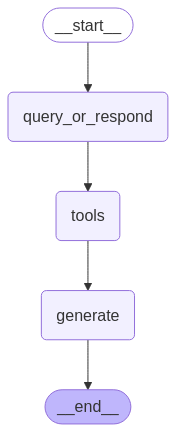

In [278]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [279]:
from langgraph.checkpoint.memory import MemorySaver

# memory = MemorySaver()
graph = graph_builder.compile()

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [226]:
sus_submissions['code'].iloc[0]

'a=input()\nx="0123456789"\nk=[0,1,2,3,4,5,6,7,8,9]\nfor i in range(len(a)) :\n    if a[i] in x:\n        if int(a[i]) not in k :\n            pass\n        else:\n           k.remove(int(a[i]))\n    else:\n        pass\nif k == []:\n    print("None")\nelse:\n    p = ""\n    for i in k:\n        p += str(i)+","\n    p=p[:-1]\n    print(p)\n'

In [227]:
user_message_content = """
Here is the code snippet to analyze:
{code}

Please classify it as either 'Human-Written' or 'AI-Generated' based on the characteristics and similarities to the provided examples.
Use the tool to retrieve similar code submissions and their authorship for comparison.
Answer in the format:
Classification: "Human-Written" or "AI-Generated"
Justification: A brief explanation of the key observations leading to this classification. Mention specific patterns, inconsistencies, or similarities to known examples.
"""

In [280]:
input_message = user_message_content.format(code=sus_submissions['code'].iloc[0])

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    for msg in step["messages"]:
        msg.pretty_print()
    # step["messages"][-1].pretty_print()

================================ Human Message =================================


Here is the code snippet to analyze:
a=input()
x="0123456789"
k=[0,1,2,3,4,5,6,7,8,9]
for i in range(len(a)) :
    if a[i] in x:
        if int(a[i]) not in k :
            pass
        else:
           k.remove(int(a[i]))
    else:
        pass
if k == []:
    print("None")
else:
    p = ""
    for i in k:
        p += str(i)+","
    p=p[:-1]
    print(p)


Please classify it as either 'Human-Written' or 'AI-Generated' based on the characteristics and similarities to the provided examples.
Use the tool to retrieve similar code submissions and their authorship for comparison.
Answer in the format:
Classification: "Human-Written" or "AI-Generated"
Justification: A brief explanation of the key observations leading to this classification. Mention specific patterns, inconsistencies, or similarities to known examples.



Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 44
}
].


================================ Human Message =================================


Here is the code snippet to analyze:
a=input()
x="0123456789"
k=[0,1,2,3,4,5,6,7,8,9]
for i in range(len(a)) :
    if a[i] in x:
        if int(a[i]) not in k :
            pass
        else:
           k.remove(int(a[i]))
    else:
        pass
if k == []:
    print("None")
else:
    p = ""
    for i in k:
        p += str(i)+","
    p=p[:-1]
    print(p)


Please classify it as either 'Human-Written' or 'AI-Generated' based on the characteristics and similarities to the provided examples.
Use the tool to retrieve similar code submissions and their authorship for comparison.
Answer in the format:
Classification: "Human-Written" or "AI-Generated"
Justification: A brief explanation of the key observations leading to this classification. Mention specific patterns, inconsistencies, or similarities to known examples.

================================== Ai Message ==================================
Tool Calls

In [108]:
sus_submissions

,id,author,problem_id,code,submission_id,score,time,not_generated
0,1804043,6630031121,05_List_11,"a=input()\nx=""0123456789""\nk=[0,1,2,3,4,5,6,7,...",1804043,100.0,over 1 year ago,False
1,2015946,6730088021,05_List_11,d = input()\ncounts = [0]*10\nfor c in d :\n ...,2015946,100.0,7 months ago,False
2,1538134,6430333521,05_List_11,"s = input()\nn = ['0','1','2','3','4','5','6',...",1538134,100.0,about 3 years ago,False
3,1537710,6130394021,05_List_11,"a = [""0"",""1"",""2"",""3"",""4"",""5"",""6"",""7"",""8"",""9""]\...",1537710,100.0,about 3 years ago,False
4,1533114,6430373621,05_List_11,"i = input()\na =[]\nb = [0,1,2,3,4,5,6,7,8,9]\...",1533114,100.0,about 3 years ago,False
...,...,...,...,...,...,...,...,...
3507,1828230,6630033421,08_Dict_22,price = {}\nfor k in range(int(input())):\n ...,1828230,100.0,over 1 year ago,False
3508,1164999,6230169821,08_Dict_22,n=int(input())\nname={}\nans=[];count=[];c=[]\...,1164999,100.0,about 5 years ago,False
3509,1749654,6532058421,08_Dict_22,n=int(input())\ndata={}\nfor i in range(n) :\n...,1749654,100.0,about 2 years ago,False
3510,1160939,6230496021,08_Dict_22,nicecream = int(input())\ndicecream = {}\nfor ...,1160939,100.0,about 5 years ago,False


In [255]:
result_df = pd.DataFrame(columns=["submission_id", "code", "author", "classification", "justification"])
result_df

,submission_id,code,author,classification,justification


In [251]:
sus_submissions['problem_id'].value_counts()

problem_id
05_List_11    2886
08_Dict_22     626
Name: count, dtype: int64

In [252]:
sus_submissions_2 = sus_submissions[sus_submissions["problem_id"] == "08_Dict_22"]

In [282]:
sus_submissions_3

,id,author,problem_id,code,submission_id,score,time,not_generated
3014,1167169,6230526121,08_Dict_22,n=int(input())\nd={}\nc={}\nmost=[]\ns=0\n\nfo...,1167169,100.0,about 5 years ago,False
3015,1929200,6630350321,08_Dict_22,price = {}\nfor k in range(int(input())):\n ...,1929200,100.0,about 1 year ago,False
3016,1807713,6631328821,08_Dict_22,n = int(input())\nl = {}\ng = 0\nwhile g != n:...,1807713,100.0,over 1 year ago,False
3017,1831547,6631227021,08_Dict_22,N = int(input())\n\nA = {}\nB = {}\nPi = {}\n\...,1831547,100.0,over 1 year ago,False
3018,1939724,6630141521,08_Dict_22,d = {}\nfor i in range(int(input())) :\n x ...,1939724,100.0,12 months ago,False
...,...,...,...,...,...,...,...,...
3507,1828230,6630033421,08_Dict_22,price = {}\nfor k in range(int(input())):\n ...,1828230,100.0,over 1 year ago,False
3508,1164999,6230169821,08_Dict_22,n=int(input())\nname={}\nans=[];count=[];c=[]\...,1164999,100.0,about 5 years ago,False
3509,1749654,6532058421,08_Dict_22,n=int(input())\ndata={}\nfor i in range(n) :\n...,1749654,100.0,about 2 years ago,False
3510,1160939,6230496021,08_Dict_22,nicecream = int(input())\ndicecream = {}\nfor ...,1160939,100.0,about 5 years ago,False


In [281]:
sus_submissions_3 = sus_submissions_2[128:]

In [284]:
for i, row in tqdm(sus_submissions_3.iterrows()):
    submission_id = row["submission_id"]
    problem_id = row["problem_id"]
    code = row["code"]
    author = row["author"]

    input_message = user_message_content.format(code=code)
    last_step = None

    for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
    ):
        last_step = step 

    if last_step:
        prediction = last_step["messages"][-1].content.split("\n")
        classification = prediction[0].split(": ")[1].strip().replace('"', "")
        justification = "\n".join(prediction[1:]).split(": ")[1].strip()
        result_df.loc[len(result_df)] = [submission_id, code, author, classification, justification]
        
    # if i == 0:
    #     break

0it [00:00, ?it/s]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 8
}
].
1it [00:07,  7.58s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds:

RetryError: Timeout of 120.0s exceeded, last exception: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 45
}
]

In [283]:
result_df

,submission_id,code,author,classification,justification
0,1547807,"def arrange(l):\n ll = []\n for no,name ...",6231211621,Human-Written,The code exhibits several characteristics typi...
1,1827099,n = int(input())\ndata = {}\nfor i in range(n)...,6631334521,Human-Written,The code exhibits several characteristics comm...
2,1923511,icecream={}\nmoney={}\nans=0\nn=int(input())\n...,6630163321,Human-Written,The code exhibits several characteristics comm...
3,1167126,n=int(input())\nb={}\nfor i in range(n):\n ...,6230250921,Human-Written,The code exhibits characteristics commonly fou...
4,1935535,iandp = {}\nfor k in range(int(input())):\n ...,6630296121,Human-Written,The code exhibits several characteristics typi...
...,...,...,...,...,...
124,1165391,n = int(input())\nmenu = {} ; sale = {}\nfor i...,6230361921,Human-Written,The code exhibits several characteristics comm...
125,1923085,n = int(input())\nkai = {}\nfor i in range(n):...,6630214721,Human-Written,The code exhibits several characteristics of h...
126,1922478,np=int(input())\npi={}\nc=[]\nfor _ in range(n...,6630305121,Human-Written,The code exhibits several characteristics comm...
127,1167169,n=int(input())\nd={}\nc={}\nmost=[]\ns=0\n\nfo...,6230526121,Human-Written,The code exhibits several characteristics comm...


In [265]:
result_df.to_csv("./data/classification_08_Dict_22.csv", index=False)

In [268]:
result_df[result_df["classification"] == "AI-Generated"]

,submission_id,code,author,classification,justification


In [267]:
result_df[result_df["classification"] == "Human-Written"]

,submission_id,code,author,classification,justification
0,1547807,"def arrange(l):\n ll = []\n for no,name ...",6231211621,Human-Written,The code exhibits several characteristics typi...
1,1827099,n = int(input())\ndata = {}\nfor i in range(n)...,6631334521,Human-Written,The code exhibits several characteristics comm...
2,1923511,icecream={}\nmoney={}\nans=0\nn=int(input())\n...,6630163321,Human-Written,The code exhibits several characteristics comm...
3,1167126,n=int(input())\nb={}\nfor i in range(n):\n ...,6230250921,Human-Written,The code exhibits characteristics commonly fou...
4,1935535,iandp = {}\nfor k in range(int(input())):\n ...,6630296121,Human-Written,The code exhibits several characteristics typi...
...,...,...,...,...,...
124,1165391,n = int(input())\nmenu = {} ; sale = {}\nfor i...,6230361921,Human-Written,The code exhibits several characteristics comm...
125,1923085,n = int(input())\nkai = {}\nfor i in range(n):...,6630214721,Human-Written,The code exhibits several characteristics of h...
126,1922478,np=int(input())\npi={}\nc=[]\nfor _ in range(n...,6630305121,Human-Written,The code exhibits several characteristics comm...
127,1167169,n=int(input())\nd={}\nc={}\nmost=[]\ns=0\n\nfo...,6230526121,Human-Written,The code exhibits several characteristics comm...


In [245]:
sus_submissions[sus_submissions["problem_id"] == "05_List_11"]

,id,author,problem_id,code,submission_id,score,time,not_generated
0,1804043,6630031121,05_List_11,"a=input()\nx=""0123456789""\nk=[0,1,2,3,4,5,6,7,...",1804043,100.0,over 1 year ago,False
1,2015946,6730088021,05_List_11,d = input()\ncounts = [0]*10\nfor c in d :\n ...,2015946,100.0,7 months ago,False
2,1538134,6430333521,05_List_11,"s = input()\nn = ['0','1','2','3','4','5','6',...",1538134,100.0,about 3 years ago,False
3,1537710,6130394021,05_List_11,"a = [""0"",""1"",""2"",""3"",""4"",""5"",""6"",""7"",""8"",""9""]\...",1537710,100.0,about 3 years ago,False
4,1533114,6430373621,05_List_11,"i = input()\na =[]\nb = [0,1,2,3,4,5,6,7,8,9]\...",1533114,100.0,about 3 years ago,False
...,...,...,...,...,...,...,...,...
2881,1150507,6230196721,05_List_11,"x = input()\nn = ['0','1','2','3','4','5','6',...",1150507,100.0,about 5 years ago,False
2882,1155049,6230237821,05_List_11,"a=input()\nb=['0','1','2','3','4','5','6','7',...",1155049,100.0,about 5 years ago,False
2883,1913393,6630262821,05_List_11,"x = ['0','1','2','3','4','5','6','7','8','9']\...",1913393,100.0,about 1 year ago,False
2884,1527451,6432043921,05_List_11,x = input()\nn = []\np = False\nfor i in range...,1527451,100.0,about 3 years ago,False
